# Top 40 ATP Elo over time

This notebook computes Elo ratings from the match CSVs (using `eloboi.py`), builds a combined timeseries for the top 40 players, and plots their Elo trajectories over time. It also saves the combined CSV and a PNG plot in `Data/`.

Requirements: pandas, numpy, matplotlib, seaborn, plotly (optional).

In [18]:
# Cell 2: Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# plotting defaults
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10


In [19]:
# Cell 3: Load matches and compute Elo

# Ensure the project root is in sys.path if running from elsewhere
import sys
proj_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if proj_root not in sys.path:
    sys.path.insert(0, os.path.abspath("."))

# Import functions/classes from eloboi
from eloboi import load_matches, EloEngine, export_top_n_players_timeseries_csv

# load matches (searches the repository for CSVs named atp_matches_*.csv)
matches = load_matches()
print(f"Loaded {len(matches)} match rows")

engine = EloEngine()
engine.compute_from_matches(matches)

# export top-40 timeseries
out_csv = "Data/elo_top40.csv"
path = export_top_n_players_timeseries_csv(engine, top_n=40, out_csv=out_csv)
print(f"Saved top-40 CSV to: {path}")


Loaded 194996 match rows
Saved top-40 CSV to: Data/elo_top40.csv
Saved top-40 CSV to: Data/elo_top40.csv


Saved plot to Data/elo_top40.png


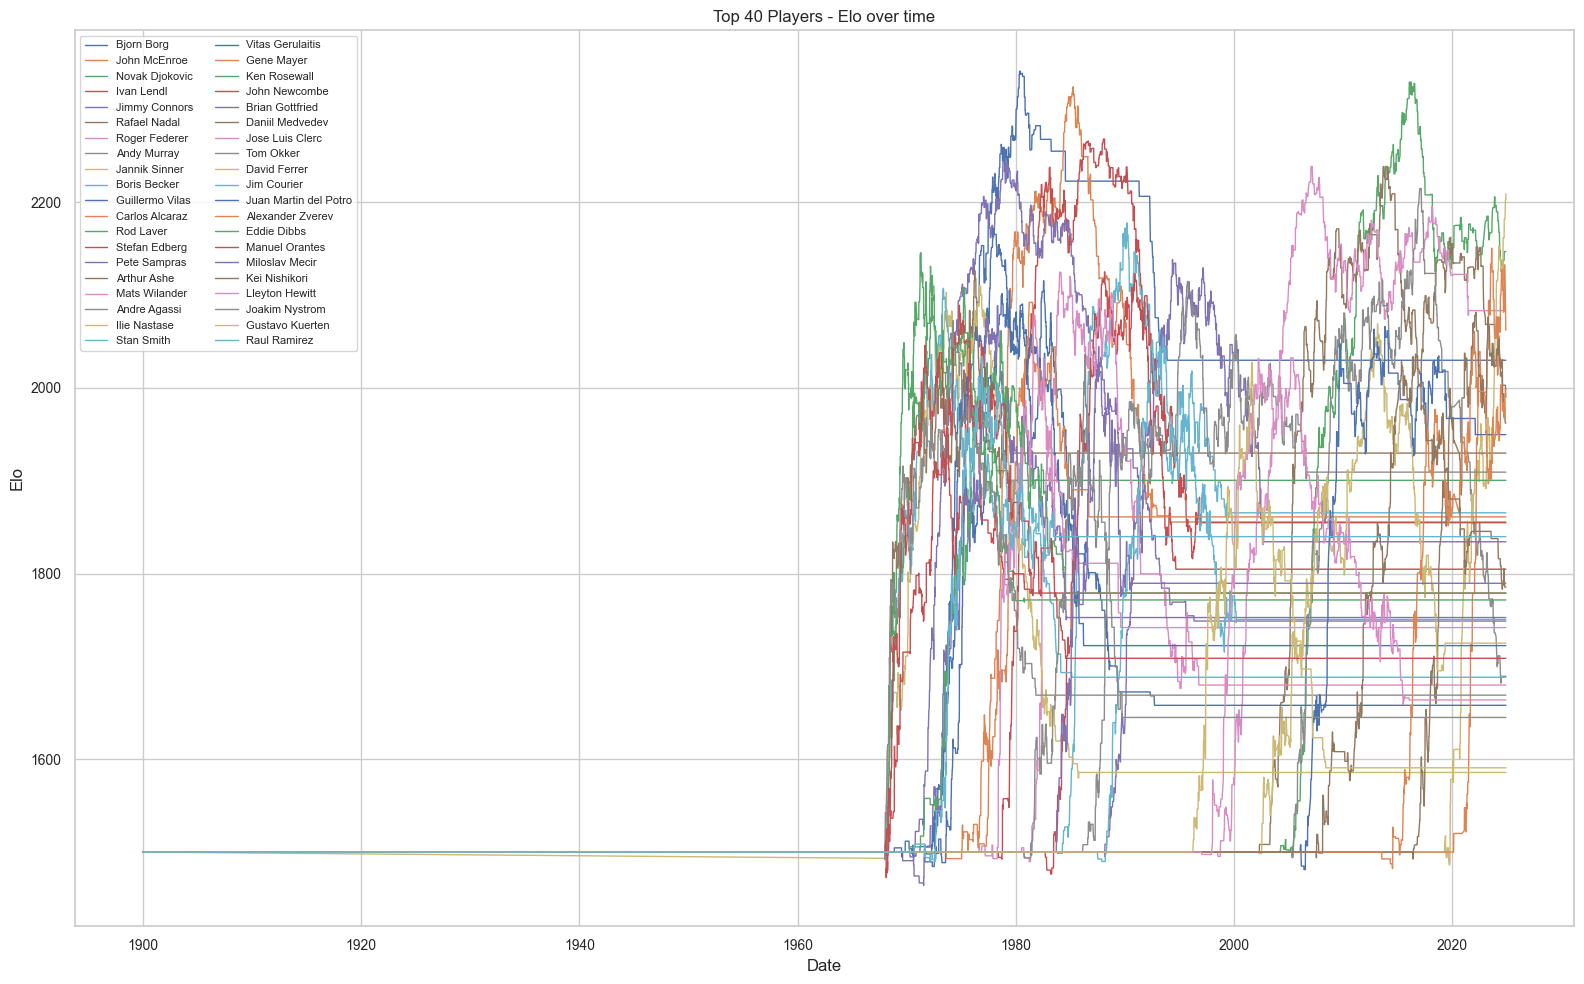

In [20]:
# Cell 4: Plot top-40 Elo time series
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "Data/elo_top40.csv"
df = pd.read_csv(csv_path, parse_dates=["date"]) 

# list of player columns (drop date)
players = [c for c in df.columns if c != "date"]

# plot
plt.figure(figsize=(16,10))
for p in players:
    plt.plot(df["date"], df[p], label=p, linewidth=1)

plt.legend(loc="upper left", fontsize=8, ncol=2)
plt.title("Top 40 Players - Elo over time")
plt.xlabel("Date")
plt.ylabel("Elo")
plt.tight_layout()

# save
out_png = "Data/elo_top40.png"
plt.savefig(out_png, dpi=200)
print(f"Saved plot to {out_png}")
plt.show()


## Interactive Plotly example and performance notes

Below is an optional Plotly snippet (commented) you can run if you have plotly installed. For performance: consider monthly resampling, downsampling, or exporting a parquet cache when working with many players.

Saved colored top-4 plot to Data/elo_top40_top4_color.png


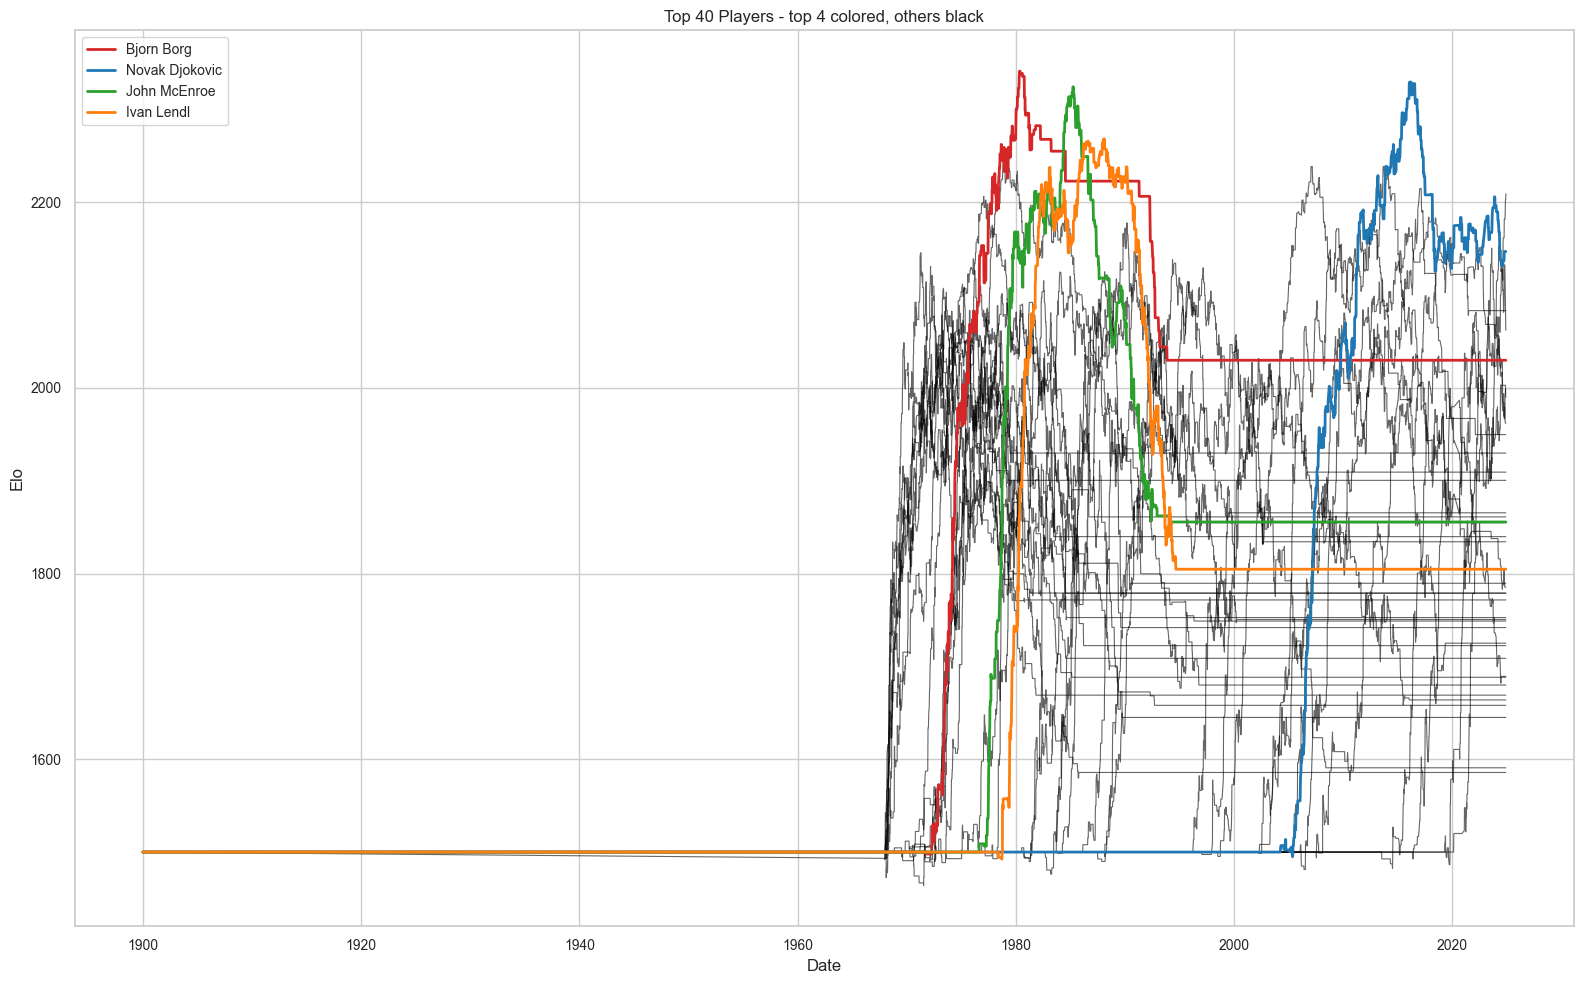

In [21]:
# Cell X: Plot top-40 with top-4 colored and others black
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "Data/elo_top40.csv"
df = pd.read_csv(csv_path, parse_dates=["date"]) 
players = [c for c in df.columns if c != "date"]

# determine top-4 by peak Elo from the DataFrame (or from previous summary)
# we'll compute peak across columns
peak_values = {p: df[p].max(skipna=True) for p in players}
sorted_players = sorted(peak_values.items(), key=lambda x: x[1], reverse=True)
top4 = [p for p,_ in sorted_players[:4]]

plt.figure(figsize=(16,10))
# plot others in black, thin lines
for p in players:
    if p in top4:
        continue
    plt.plot(df["date"], df[p], color="black", alpha=0.6, linewidth=0.8)

# assign distinct colors for top4
colors = ["tab:red", "tab:blue", "tab:green", "tab:orange"]
for color, p in zip(colors, top4):
    plt.plot(df["date"], df[p], label=p, color=color, linewidth=2.0)

plt.legend(loc="upper left", fontsize=10)
plt.title("Top 40 Players - top 4 colored, others black")
plt.xlabel("Date")
plt.ylabel("Elo")
plt.tight_layout()

out_png = "Data/elo_top40_top4_color.png"
plt.savefig(out_png, dpi=200)
print(f"Saved colored top-4 plot to {out_png}")
plt.show()


Saved colored top-4 plot to Data/elo_top40_top4_specific_color.png


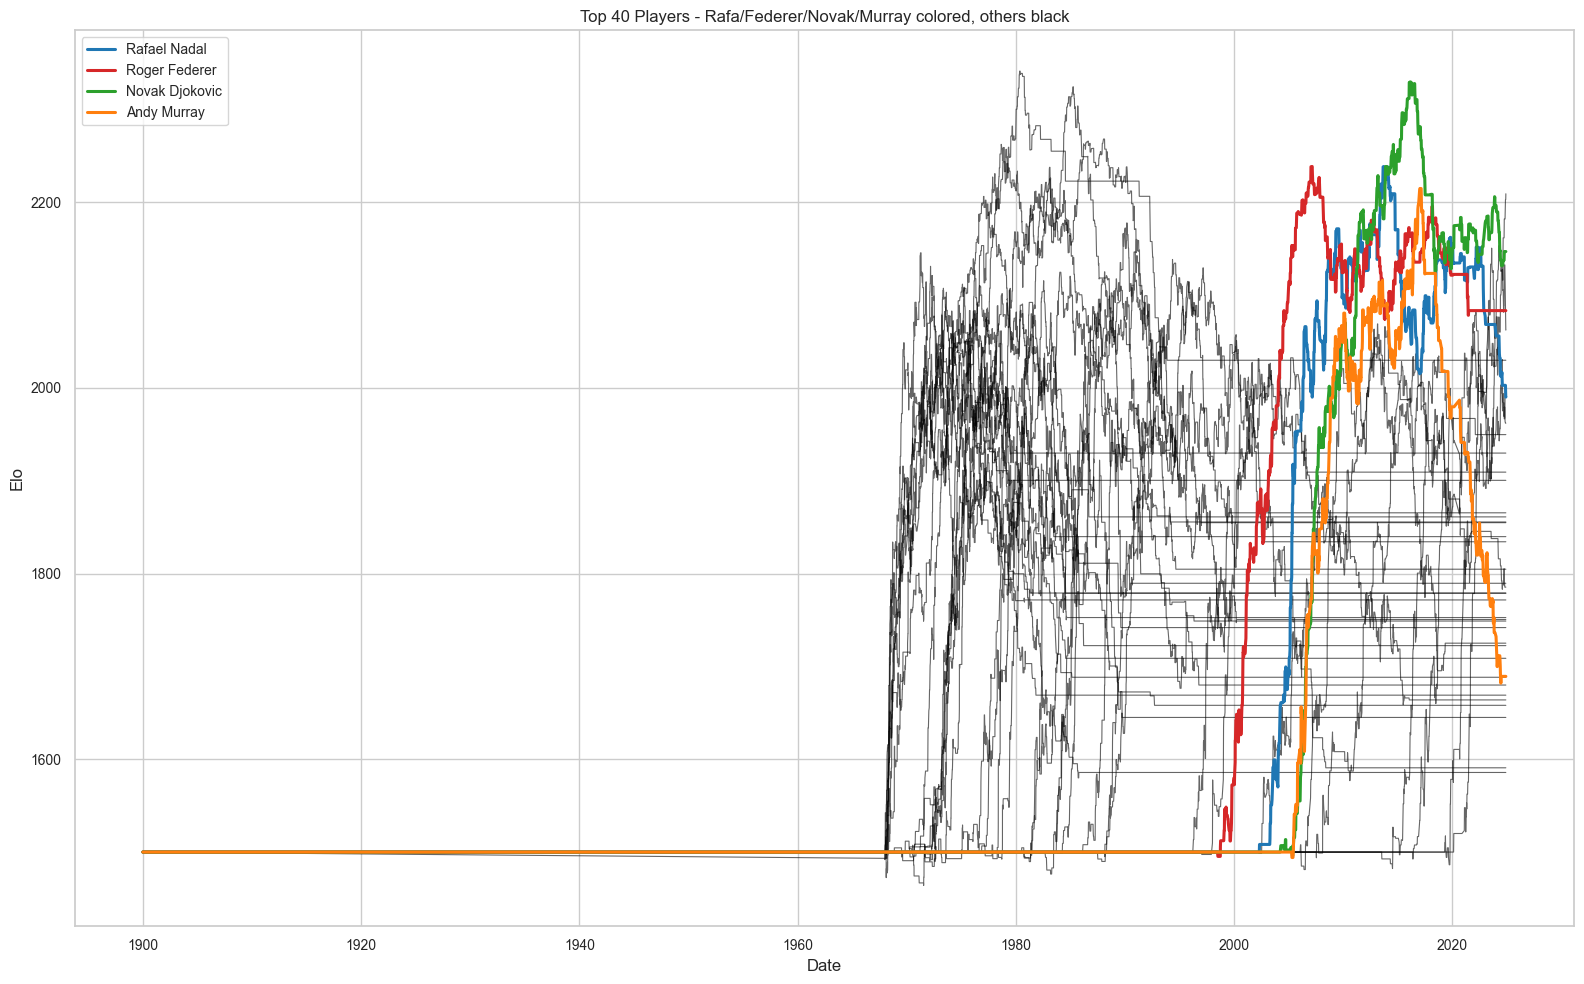

In [22]:
# New cell: Plot top-40 with Rafa/Federer/Novak/Murray colored and others black
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "Data/elo_top40.csv"
df = pd.read_csv(csv_path, parse_dates=["date"])
players = [c for c in df.columns if c != "date"]

# explicit top-4 players you requested
requested_top4 = ["Rafael Nadal", "Roger Federer", "Novak Djokovic", "Andy Murray"]
# filter to those actually present in the data
present_top4 = [p for p in requested_top4 if p in players]
others = [p for p in players if p not in present_top4]

plt.figure(figsize=(16,10))
# plot others in black, thin lines
for p in others:
    plt.plot(df["date"], df[p], color="black", alpha=0.6, linewidth=0.8)

# assign distinct colors for the requested top4 (order matches present_top4)
color_map = {
    "Rafael Nadal": "tab:blue",
    "Roger Federer": "tab:red",
    "Novak Djokovic": "tab:green",
    "Andy Murray": "tab:orange",
}
for p in present_top4:
    plt.plot(df["date"], df[p], label=p, color=color_map.get(p, None), linewidth=2.2)

plt.legend(loc="upper left", fontsize=10)
plt.title("Top 40 Players - Rafa/Federer/Novak/Murray colored, others black")
plt.xlabel("Date")
plt.ylabel("Elo")
plt.tight_layout()

out_png = "Data/elo_top40_top4_specific_color.png"
plt.savefig(out_png, dpi=200)
print(f"Saved colored top-4 plot to {out_png}")
plt.show()


Saved era-clipped top-4 plot to Data/elo_top40_top4_era.png


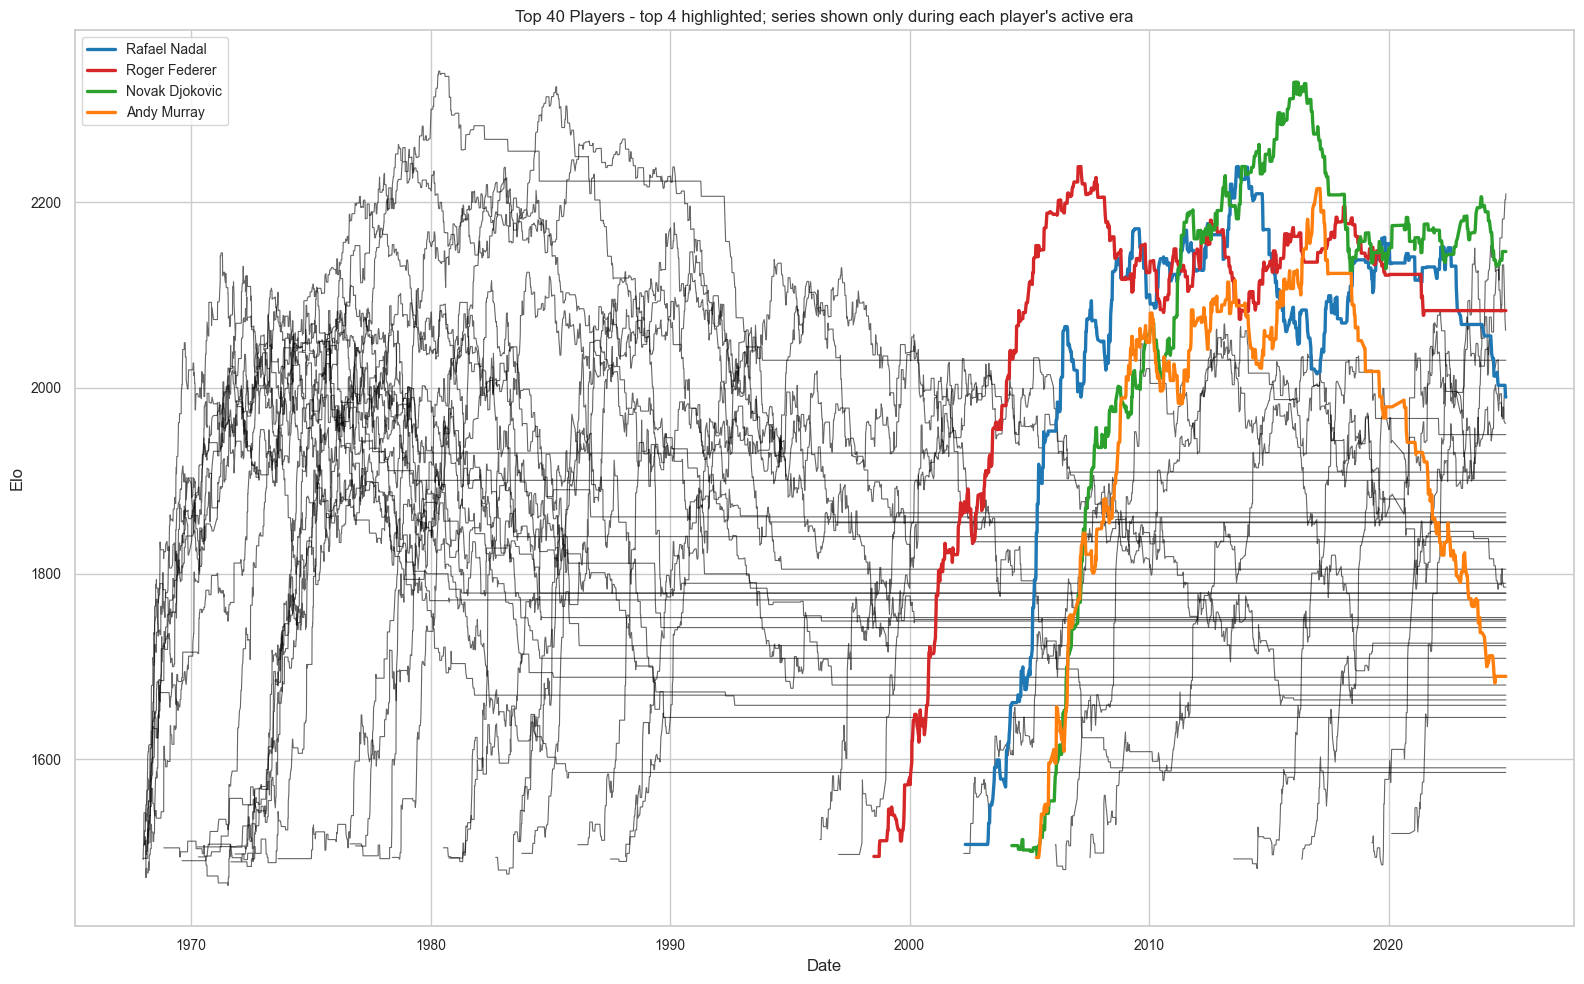

In [23]:
# New cell: Plot each player's Elo only during their active era; color Rafa/Federer/Novak/Murray
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "Data/elo_top40.csv"
df = pd.read_csv(csv_path, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
players = [c for c in df.columns if c != "date"]

# determine active era per player: first/last date where rating differs from baseline 1500
era = {}
for p in players:
    ser = df[p]
    mask = ser.notna() & (ser != 1500)
    if mask.any():
        start = df.loc[mask, 'date'].iloc[0]
        end = df.loc[mask, 'date'].iloc[-1]
        era[p] = (pd.to_datetime(start), pd.to_datetime(end))
    else:
        # fallback: if never departs from 1500, skip plotting
        era[p] = (None, None)

# requested highlighted players
highlight = ["Rafael Nadal", "Roger Federer", "Novak Djokovic", "Andy Murray"]
colors = {"Rafael Nadal": "tab:blue", "Roger Federer": "tab:red", "Novak Djokovic": "tab:green", "Andy Murray": "tab:orange"}

plt.figure(figsize=(16,10))

# plot non-highlighted players in black, limited to their era
for p in players:
    s, e = era.get(p, (None, None))
    if s is None or e is None:
        continue
    if p in highlight:
        continue
    # slice rows between s and e (inclusive)
    mask = (df['date'] >= s) & (df['date'] <= e)
    if not mask.any():
        continue
    plt.plot(df.loc[mask, 'date'], df.loc[mask, p], color='black', alpha=0.6, linewidth=0.8)

# plot highlighted players with color, also limited to their era
for p in highlight:
    if p not in players:
        print(f"Warning: {p} not found in data; skipping")
        continue
    s, e = era.get(p, (None, None))
    if s is None or e is None:
        # if no era found, plot full available range
        plt.plot(df['date'], df[p], label=p, color=colors.get(p), linewidth=2.2)
        continue
    mask = (df['date'] >= s) & (df['date'] <= e)
    if not mask.any():
        continue
    plt.plot(df.loc[mask, 'date'], df.loc[mask, p], label=p, color=colors.get(p), linewidth=2.4)

plt.legend(loc='upper left', fontsize=10)
plt.title('Top 40 Players - top 4 highlighted; series shown only during each player\'s active era')
plt.xlabel('Date')
plt.ylabel('Elo')
plt.tight_layout()

out_png = 'Data/elo_top40_top4_era.png'
plt.savefig(out_png, dpi=200)
print(f"Saved era-clipped top-4 plot to {out_png}")
plt.show()


Saved common-window plot to Data/elo_top40_top4_common_window.png


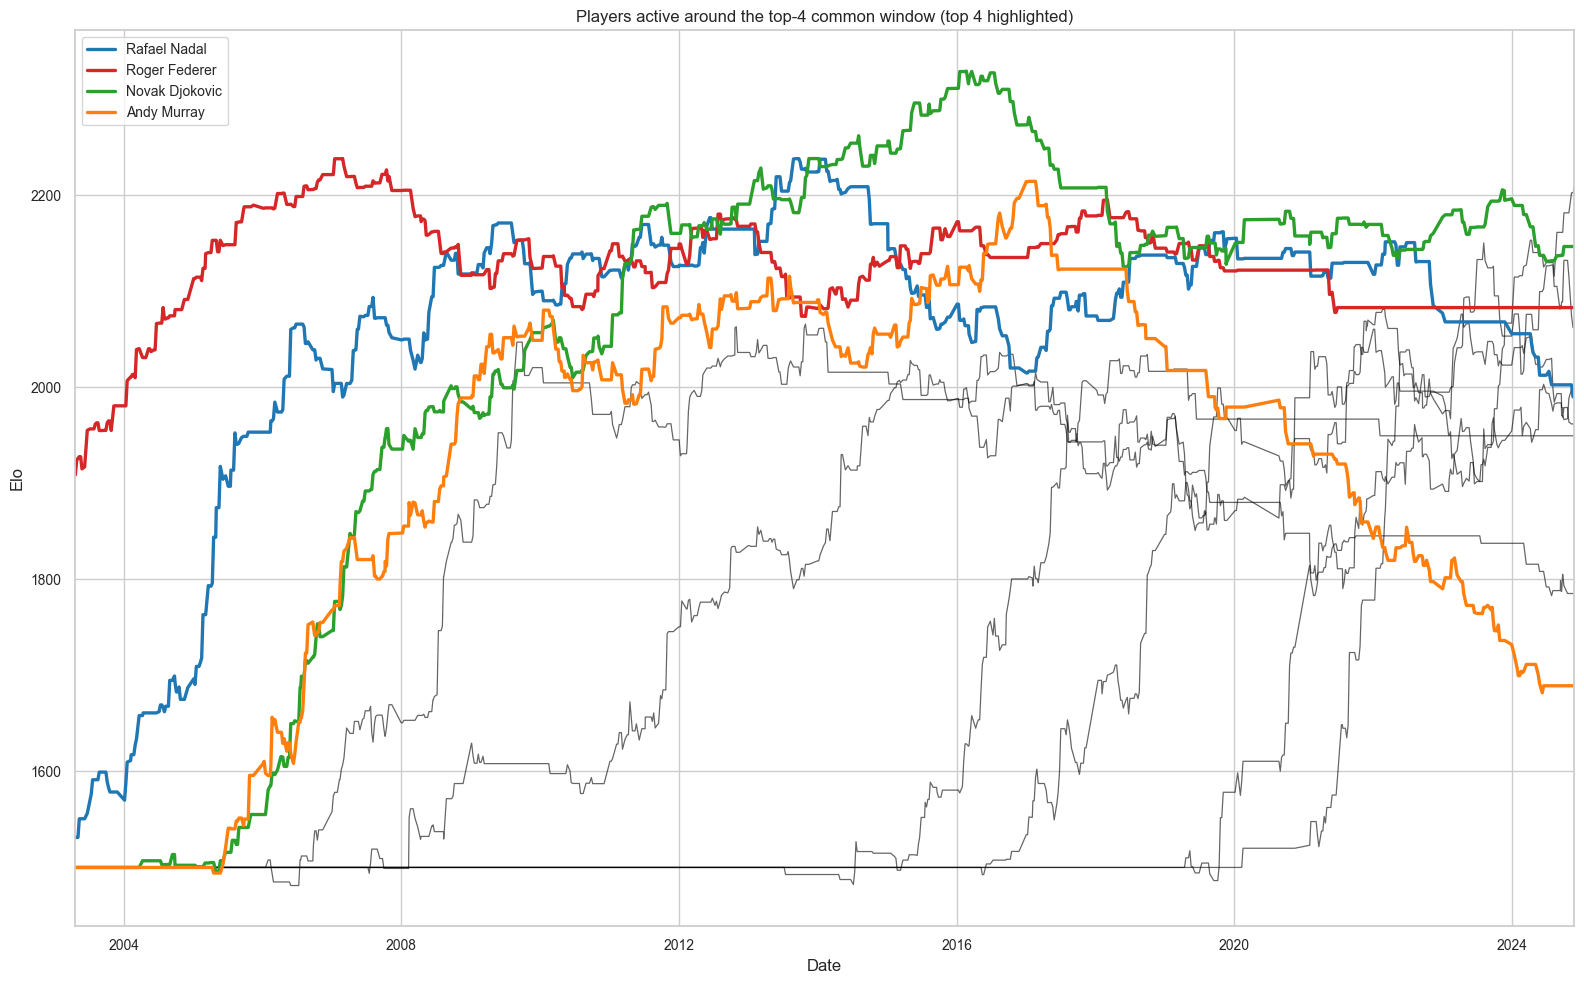

In [24]:
# New cell: Plot players whose careers overlap the top-4 common window
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

csv_path = "Data/elo_top40.csv"
df = pd.read_csv(csv_path, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
players = [c for c in df.columns if c != "date"]

# Define the four players
four = ["Rafael Nadal", "Roger Federer", "Novak Djokovic", "Andy Murray"]

# compute era starts/ends (first and last date where rating != 1500)
era = {}
for p in players:
    ser = df[p]
    mask = ser.notna() & (ser != 1500)
    if mask.any():
        start = df.loc[mask, 'date'].iloc[0]
        end = df.loc[mask, 'date'].iloc[-1]
        era[p] = (pd.to_datetime(start), pd.to_datetime(end))
    else:
        era[p] = (None, None)

# find the overlapping window for the four players: use latest of starts and earliest of ends if possible
starts = [era[p][0] for p in four if era.get(p) and era[p][0] is not None]
ends = [era[p][1] for p in four if era.get(p) and era[p][1] is not None]
if starts and ends:
    common_start = max(starts)
    common_end = min(ends)
else:
    # fallback: use global min/max
    common_start = df['date'].min()
    common_end = df['date'].max()

# Expand the window slightly to include players who began around the same time
window_start = common_start - pd.DateOffset(years=2)
window_end = common_end

# select players who have a start within +/- 2 years of common_start
selected = []
for p in players:
    s, e = era.get(p, (None, None))
    if s is None:
        continue
    # if player's start is within the expanded window_start..common_end
    if s <= window_end and s >= window_start:
        selected.append(p)

# Ensure the four players are included
for p in four:
    if p in players and p not in selected:
        selected.append(p)

plt.figure(figsize=(16,10))
# plot selected players (others skipped) — non-highlighted in black
for p in selected:
    if p in four:
        continue
    s, e = era.get(p, (None, None))
    mask = (df['date'] >= window_start) & (df['date'] <= window_end)
    plt.plot(df.loc[mask, 'date'], df.loc[mask, p], color='black', alpha=0.6, linewidth=0.9)

# plot the four highlighted players in color
color_map = {"Rafael Nadal": "tab:blue", "Roger Federer": "tab:red", "Novak Djokovic": "tab:green", "Andy Murray": "tab:orange"}
for p in four:
    if p not in players:
        continue
    mask = (df['date'] >= window_start) & (df['date'] <= window_end)
    plt.plot(df.loc[mask, 'date'], df.loc[mask, p], label=p, color=color_map.get(p), linewidth=2.4)

plt.legend(loc='upper left', fontsize=10)
plt.title('Players active around the top-4 common window (top 4 highlighted)')
plt.xlabel('Date')
plt.ylabel('Elo')
plt.xlim(window_start, window_end)
plt.tight_layout()

out_png = 'Data/elo_top40_top4_common_window.png'
plt.savefig(out_png, dpi=200)
print(f"Saved common-window plot to {out_png}")
plt.show()


Saved fixed plot to Data/elo_latest400_top4_highlight_fixed.png


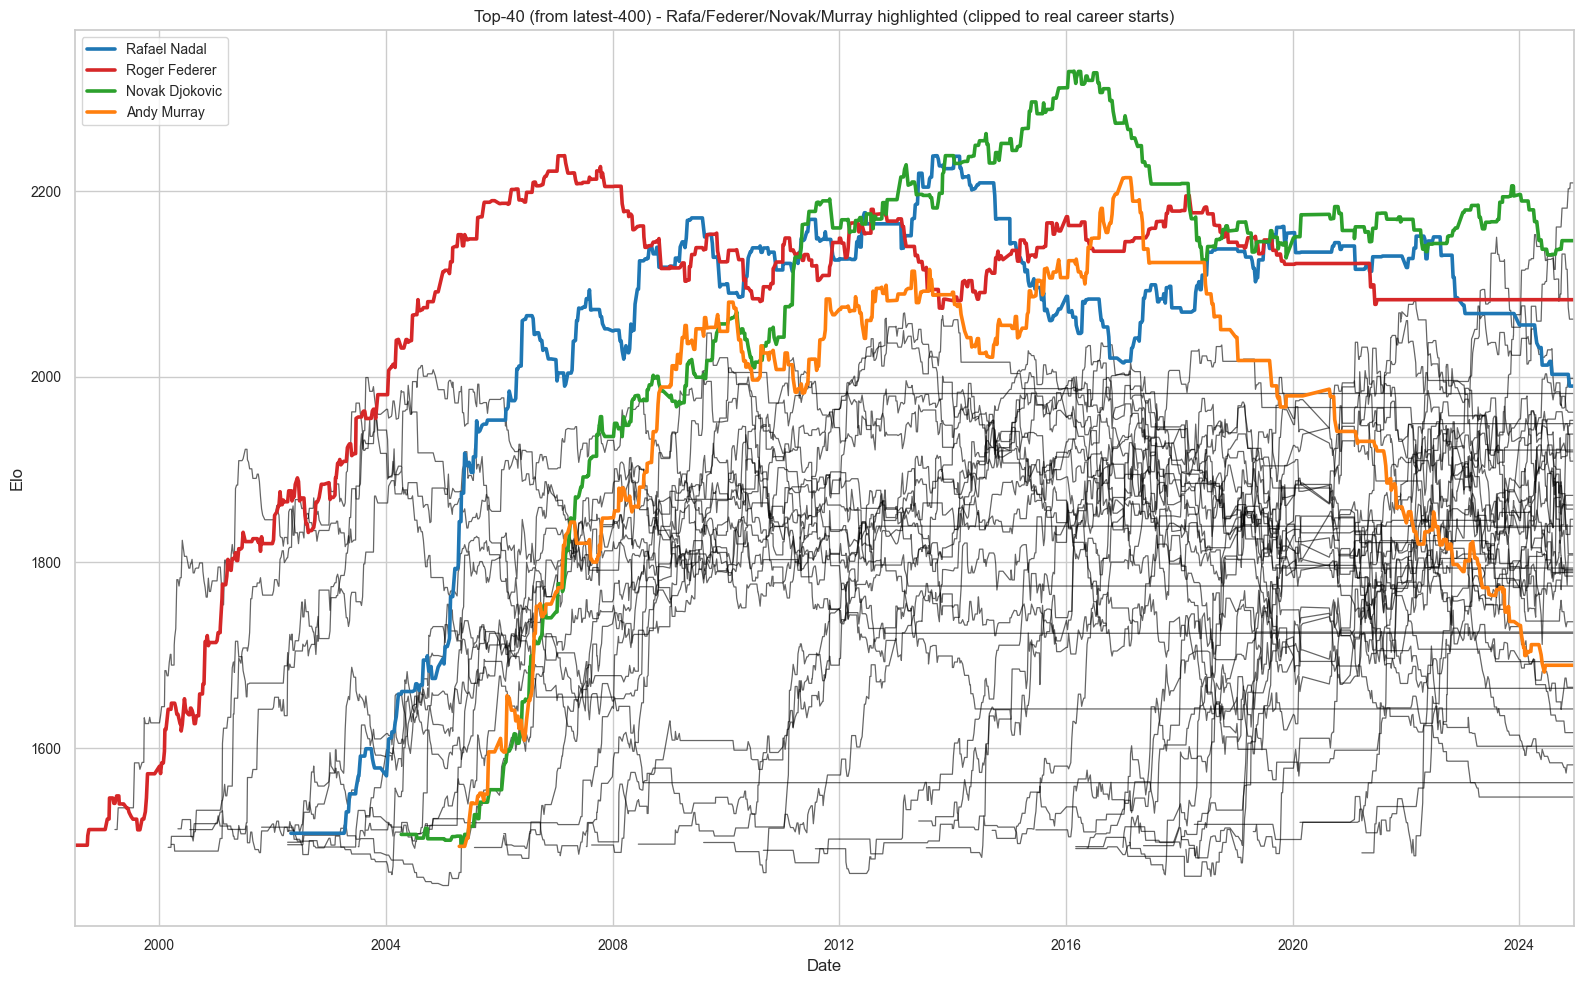

In [26]:
# Fixed plot: highlight Rafa/Federer/Novak/Murray and clip each series to player's real start (no 1900 rows)
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "Data/elo_from_federer_start.csv"
df = pd.read_csv(csv_path, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
players = [c for c in df.columns if c != "date"]

# choose top-40 by peak Elo inside this CSV
peak_vals = {p: df[p].max(skipna=True) for p in players}
sorted_players = sorted(peak_vals.items(), key=lambda x: x[1], reverse=True)
selected_top40 = [p for p,_ in sorted_players[:40]]

# Ensure highlighted players are present and included
highlight = ["Rafael Nadal", "Roger Federer", "Novak Djokovic", "Andy Murray"]
for h in highlight:
    if h in players and h not in selected_top40:
        selected_top40.insert(0, h)  # ensure they appear and are plotted

# helper to find player's first real date (value != 1500 and not null)
def player_start_date(series: pd.Series) -> pd.Timestamp | None:
    mask = series.notna() & (series != 1500)
    if not mask.any():
        return None
    return series.index[mask.argmax()] if False else series.index[mask.values.argmax()]

# Better: use df to find date of first non-1500
start_dates = {}
for p in selected_top40:
    ser = df[p]
    mask = ser.notna() & (ser != 1500)
    if mask.any():
        start_dates[p] = df.loc[mask, 'date'].iloc[0]
    else:
        # if never departs from 1500, set to None
        start_dates[p] = None

# Determine overall plot x-limits: earliest of highlighted starts (if available)
highlight_starts = [d for p,d in start_dates.items() if p in highlight and d is not None]
if highlight_starts:
    x_min = min(highlight_starts)
else:
    x_min = df['date'].min()

# Plot
plt.figure(figsize=(16,10))
# plot non-highlighted selected players in black, but clipped to their start
for p in selected_top40:
    if p in highlight:
        continue
    sdate = start_dates.get(p)
    if sdate is None:
        continue
    mask = df['date'] >= sdate
    plt.plot(df.loc[mask, 'date'], df.loc[mask, p], color='black', alpha=0.6, linewidth=0.9)

# plot highlighted players with colors, clipped to their start
color_map = {"Rafael Nadal": "tab:blue", "Roger Federer": "tab:red", "Novak Djokovic": "tab:green", "Andy Murray": "tab:orange"}
for p in highlight:
    if p not in players:
        print(f"Warning: {p} not in data; skipping")
        continue
    sdate = start_dates.get(p)
    if sdate is None:
        # plot from earliest available date if no start detected
        mask = df['date'] >= x_min
    else:
        mask = df['date'] >= sdate
    plt.plot(df.loc[mask, 'date'], df.loc[mask, p], label=p, color=color_map.get(p, None), linewidth=2.6)

plt.legend(loc='upper left', fontsize=10)
plt.title('Top-40 (from latest-400) - Rafa/Federer/Novak/Murray highlighted (clipped to real career starts)')
plt.xlabel('Date')
plt.ylabel('Elo')
plt.xlim(x_min, df['date'].max())
plt.tight_layout()
out_png = 'Data/elo_latest400_top4_highlight_fixed.png'
plt.savefig(out_png, dpi=200)
print(f"Saved fixed plot to {out_png}")
plt.show()
